# Lab 4: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1JPc-XjSu28LyM1iNf9mSp4LRnx9BwajJ/view?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install -U torch==1.8.0 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(42)

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

A)

Label for spam = spam

Label for non-spam = ham

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

spam_flag = False
ham_flag = False

for line in open('/content/gdrive/My Drive/SMSSpamCollection'):
    msg = line.split('\t')
    if msg[0] == 'ham' and ham_flag == False:
        print("Ham Message = ", msg)
        ham_flag = True

    elif msg[0] == 'spam' and spam_flag == False:
        print("Spam Message = ", msg)
        spam_flag = True

    if ham_flag and spam_flag:
        break

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Ham Message =  ['ham', 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n']
Spam Message =  ['spam', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n"]


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spams = 0
hams = 0

for line in open('/content/gdrive/My Drive/SMSSpamCollection'):
    msg = line.split('\t')
    if msg[0] == 'ham':
        hams+=1

    elif msg[0] == 'spam':
        spams += 1

print("# spams: ", spams)
print("# hams: ", hams)

# spams:  747
# hams:  4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.


A)
Advantages:

1) Lesser memory will be needed to store embeddings because there are fewer possibilities for distinct characters than words

2) Generalization to unknown words will be easier with character-level modelling, which is particularly relevant to texting because individuals may permute characters differently (intentionally or unintentionally) to express the same ideas/words during texting (e.g., "hahahaha" vs. "haha", "texting" vs. "txtng")  

Disadvantages:

1) With character-level modelling, the model will even accept non-words as words. This is an important issue because spam messages can often be intentionally poor in grammar to catch gullible individuals, and the model will not be able to filter for this

2) Character-level modelling will prevent the model from inferring relationships between related words, weakening its predictive ability

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True, tokenize=lambda x: x, include_lengths=True,
                                  batch_first=True, use_vocab=True)
label_field = torchtext.legacy.data.Field(sequential=False, use_vocab=False,
                                   is_target=True, batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam'))

fields = [('label', label_field), ('sms', text_field)]
data = torchtext.legacy.data.TabularDataset('/content/gdrive/My Drive/SMSSpamCollection',
                                        "tsv", fields)

train, valid, test = data.split(split_ratio=[0.6, 0.2, 0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

A)

A balanced set reduces bias in predictions by preventing the model from orienting its weights towards the more frequent training label. In the absence of balance, the highest accuracy models could often simply predict the heavily-skewed classes, which would inhibit their generalizability.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

A)

stoi is a dictionary of the numeric identifier of each character token. itos is a list of all character tokens found in the training set.

In [ ]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fda1a025dd0>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, '.': 15, 'd': 16, 'm': 17, 'c': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'S': 33, 'C': 34, 'O': 35, 'I': 36, '4': 37, 'N': 38, '7': 39, '3': 40, 'A': 41, 'x': 42, '6': 43, 'R': 44, ',': 45, '!': 46, 'P': 47, '9': 48, 'M': 49, 'W': 50, 'L': 51, 'H': 52, 'U': 53, 'D': 54, 'G': 55, 'B': 56, 'F': 57, 'Y': 58, '?': 59, "'": 60, '/': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'z': 66, 'V': 67, 'X': 68, 'j': 69, 'K': 70, '*': 71, ')': 72, 'J': 73, ';': 74, '+': 75, '(': 76, 'q': 77, 'Q': 78, '#': 79, '"': 80, '>': 81, '=': 82, '@': 83, 'Z': 84, 'ü': 85, '$': 86, '|': 87, '%': 88, '‘': 89, 'Ü': 90, '<': 91, '\x92': 92, '[': 93, ']': 94, '“': 95, '_': 96, '…': 97, '\x93': 98,

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

A)
`<unk>` represents the unknown token, for words outside our vocabulary.
`<pad>` represents the tokens added for padding, so that each message's length is compatible with the chosen batch size.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train, batch_size=32,
                                                  sort_key=lambda x: len(x.sms),
                                                  sort_within_batch=True,
                                                  repeat=False)

In [ ]:
counter = 0
pad_counts = []
max_lens = []
for batch in train_iter:
    if counter <10:
        max_len = 0
        pad_counter = 0
        for msg in batch.sms[0]:
            if len(msg) > max_len:
                max_len = len(msg)

            for token in msg:
                if token == text_field.vocab.stoi["<pad>"]:
                    pad_counter +=1
        pad_counts.append(pad_counter)
        max_lens.append(max_len)

    else:
        break

    counter += 1

print("pad_counts = ", pad_counts)
print("max lengths = ", max_lens)

pad_counts =  [0, 0, 9, 33, 0, 54, 39, 30, 0, 29]
max lengths =  [155, 156, 81, 31, 160, 104, 50, 39, 154, 65]


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
iden = torch.eye(len(text_field.vocab.itos))

In [ ]:
torch.manual_seed(42)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(iden)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self,x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # last step comprises max pooling
        output = self.fc(torch.max(out, dim=1)[0])
        return output

In [ ]:
model = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    corr = 0
    tot = 0

    iterable = torchtext.legacy.data.BucketIterator(data, batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

    for item in iterable:
        output = model(item.sms[0])
        pred = output.max(1, keepdim = True)[1]
        corr += pred.eq(item.label.view_as(pred)).sum().item()
        tot += item.label.shape[0]

    acc = corr/tot

    return acc

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
def train_RNN(model,train,valid,num_epochs = 5,lr = 1e-4):
    losses = []
    train_accs = []
    val_accs = []
    eps = []
    crit = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(),lr = lr)
    train_iterator = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

    for epoch in range(num_epochs):
        print("Epoch ", epoch)
        eps.append(epoch)
        for item in train_iterator:
            optim.zero_grad()
            pred = model(item.sms[0])
            loss = crit(pred,item.label)
            loss.backward()
            optim.step()

        losses.append(float(loss))
        train_accs.append(get_accuracy(model, train))
        val_accs.append(get_accuracy(model, valid))
    print("Loss = ", losses[-1])
    print("Train Acc = ", train_accs[-1])
    print("Val Acc = ", val_accs[-1])

    plt.title("Loss vs. Epochs")
    plt.plot(eps, losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy vs. Epochs")
    plt.plot(eps, train_accs, label = "Training")
    plt.plot(eps, val_accs, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc = 'best')
    plt.show()

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Loss =  0.06565544009208679
Train Acc =  0.9808555189949147
Val Acc =  0.9721973094170404


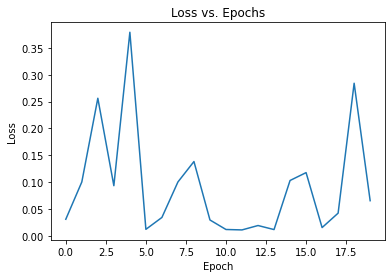

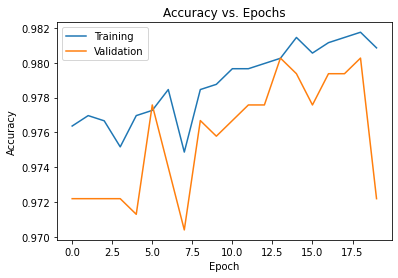

In [ ]:
model1 = train_RNN(model, train, valid, num_epochs = 20)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

A)

I started by decreasing my learning rate from 1e-4 to 1e-5 because I saw a lot of oscillation in my original model's loss function.

That increased my loss oscillations and decreased my accuracy, however, so I decided to keep my original learning rate and follow up by increasing the number of epochs to 30 to enable greater accuracy.

That did improve my validation accuracy from 97.29% to 97.94%, so while I decided that I would use 30 epochs in my final model, I used 20 epochs for further testing because the 10 additional epochs only increased validation accuracy by <0.7% and didn't seem worth the additional training time. Next, I tried changing the number of hidden layers to 75. My validation accuracy was fairly comparable to my original model with, but slightly lower, so I decided to stick to my original decision of hidden layers = # of characters in the vocabulary.

Lastly I tried to use a concatenation of average and max pooling for my class definition instead of just max pooling over the entire array. This also gave me a lower validation accuracy than my original model, however, so I decided to retain my original max pooling model.

My model has 30 epochs, lr of 1e-4, hidden layers equal to the vocabulary length and max pooling over the entire array. My final validation accuracy in this architecture was 97.94%.

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Loss =  0.314963161945343
Train Acc =  0.8680825605743344
Val Acc =  0.8654708520179372


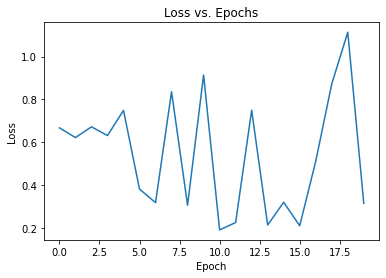

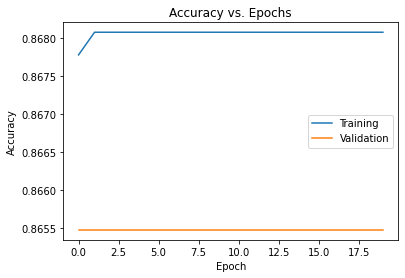

In [ ]:
# Try tuning learning rate
model = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)
model2 = train_RNN(model, train, valid, num_epochs=20, lr=1e-5)

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24
Epoch  25
Epoch  26
Epoch  27
Epoch  28
Epoch  29
Loss =  0.16466474533081055
Train Acc =  0.9799581214478014
Val Acc =  0.979372197309417


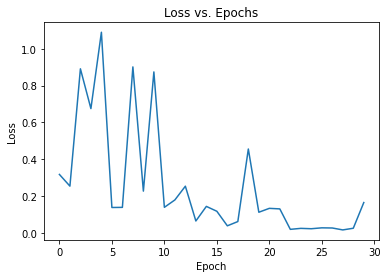

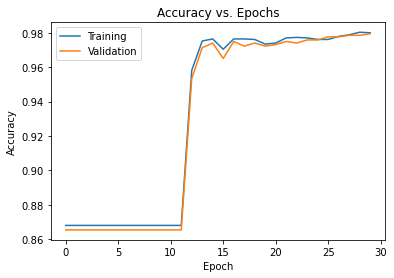

In [ ]:
# Try tuning hidden state size
model = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)
model3 = train_RNN(model, train, valid, num_epochs=30)

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Loss =  0.09754782170057297
Train Acc =  0.97517200119653
Val Acc =  0.968609865470852


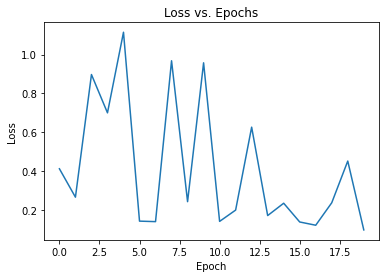

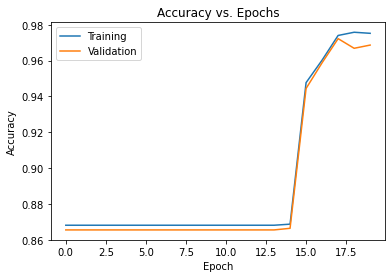

In [ ]:
# Try tuning hidden state size
model = RNN(len(text_field.vocab.itos), 75, 2)
model4 = train_RNN(model, train, valid, num_epochs=20)

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Loss =  0.11288277059793472
Train Acc =  0.9712832784923722
Val Acc =  0.9668161434977578


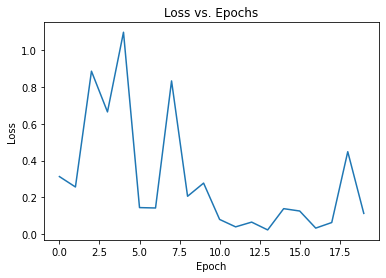

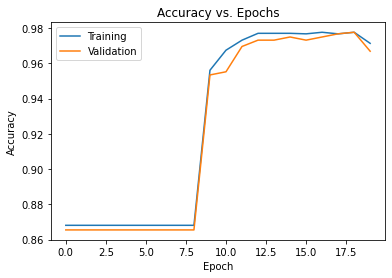

In [ ]:
# Try tuning RNN output pooling

class RNN_modif(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN_modif, self).__init__()
        self.emb = nn.Embedding.from_pretrained(iden)
        self.hidden_size = hidden_size  # Hyperparameter, can change
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Concat of max and average pooling of RNN outputs (Hyperparameter, can change)
        out = torch.cat((torch.max(out, dim=1)[0], torch.mean(out, dim=1)), dim=1)
        out = self.fc(out)
        return out

model = RNN_modif(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)
model5 = train_RNN(model, train, valid, num_epochs=20)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

fn = 1 - get_accuracy(model, valid_spam)
fp = 1 - get_accuracy(model, valid_nospam)

print("False Negative Rate: ", fn)
print("False Positives Rate: ", fp)

False Negative Rate:  0.09999999999999998
False Positives Rate:  0.022797927461139844


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

A) False positive would lead to non-spam messages being classified as spam and the user not reading them. This can be very harmful as users may miss important texts filtered by the model.

False negative would lead to spam messages being classified as non-spam and users having to read them. These are less harmful as spam texts, while irritating, are typically easily ignored by the user. However, if the user falls for a scam in the spam tests, these can also be very damaging.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

A)

My final test accuracy was 97.4%

In [ ]:
model_test = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)
train_RNN(model_test, train, valid, num_epochs=30)
print("Final Test Accuracy = ", get_accuracy(model_test, test))

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    valid.fields)

fn = 1 - get_accuracy(model_test, valid_spam)
fp = 1 - get_accuracy(model_test, valid_nospam)

print("False Negative Rate: ", fn)
print("False Positives Rate: ", fp)

NameError: ignored

### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

A)

My model predicts a 1.46% spam probability.

In [ ]:
msg = "machine learning is sooo cool!"

tokens = []

for token in msg:
    tokens.append(torch.tensor(text_field.vocab.stoi[token]))

t = torch.stack(tokens)
t = t.unsqueeze(0)

out = torch.softmax(model_test(t), dim = 1)[0][1].item()
print("Spam probability = ", out)

Spam probability =  0.014641212299466133


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**


A)

Detecting spam is a difficult task because spam what constitutes spam can vary from person to person. For example, messages regarding bitcoins may be spam for doctors but non-spam for crypto traders. Therefore, we need individual-specific data and lots of it to build highly accurate models, but that may not always be available depending on how proactively the individual classifies messages as spam.

For the baseline model, I would use a decision tree. I would take the messages database with labels and input each message (using split function like in this model) so that the tree can evaluate the probability of a message being spam given the presence of characters present in the message. I would use scikit learn library to readily use decision tree related functions for this task.